## Importing libraries


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 25 23:26:42 2023

@author: DELL
"""

 #%%
import matplotlib
import pathlib
import os
import mne
import csv
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
from mne.io import read_raw_eeglab
from mne_bids import BIDSPath, get_entity_vals, find_matching_paths
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import sklearn
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
mne.set_log_level('warning')
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Data will be preloaded.*")
print('done')

done


## Functions

In [2]:
# Function to plot training and validation accuracy/loss
def training_plot(history):
    # Extract training and validation accuracy and loss from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    # Plot training and validation loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
import matplotlib.pyplot as plt

def plot_accuracy(histories):
    plt.figure(figsize=(10, 6))
    
    for history in histories:
        acc = history.history['accuracy']
        #val_acc = history.history['val_accuracy']
        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, label='Training acc')
        #plt.plot(epochs, val_acc, label='Validation acc')

    plt.title('Training Acuraccy for each Fold in LOSO')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    #plt.legend()
    plt.grid(True)
    plt.show()


def calculate_metrics_and_plot(confusion_true_MLP, confusion_pred_MLP):
    # Calculate confusion matrix
    confusion_mtx = confusion_matrix(confusion_true_MLP, confusion_pred_MLP)

    # Define class names
    class_names = ["Control-CN(0)", " Alzhaimer-AD(1)"]

    # Calculate accuracy, sensitivity, specificity, precision, and F1-score
    accuracy = accuracy_score(confusion_true_MLP, confusion_pred_MLP)
    precision = precision_score(confusion_true_MLP, confusion_pred_MLP)
    recall = recall_score(confusion_true_MLP, confusion_pred_MLP)
    f1 = f1_score(confusion_true_MLP, confusion_pred_MLP)
    specificity = confusion_mtx[0, 0] / (confusion_mtx[0, 0] + confusion_mtx[0, 1])

    # Output metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Sensitivity (Recall):", recall)
    print("Specificity:", specificity)
    print("F1-score:", f1)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(confusion_true_MLP, confusion_pred_MLP)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()






def segmentation(data, labels, segment_duration=20):
    segmented_data, segmented_labels, idx = [], [], -1
    segmented_2D,segmented_2D_labels = [],[]
    overlap_duration = segment_duration * 0.5

    for raw0 in data:
        temp_2D=[]
        temp_2D_labels=[]
        idx = idx + 1
        total_duration = raw0.times[-1]
        num_segments = int(total_duration // (segment_duration - overlap_duration)-1)
        print(raw0)

        for ii in range(num_segments):
            start_time = ii * (segment_duration - overlap_duration)
            end_time = min(start_time + segment_duration, total_duration)  # Ensure end_time doesn't exceed total_duration
            
            segment = raw0.copy().crop(tmin=start_time, tmax=end_time)
            segment_data = segment.get_data()
            
            segmented_data.append(segment)
            temp_2D.append(np.array(segment_data))
            
            segmented_labels.append(labels[idx])
            temp_2D_labels.append(labels[idx])
            
        
        segmented_2D.append(np.array(temp_2D))
        segmented_2D_labels.append(np.array(temp_2D_labels))
        print(end_time)
        

    # Create an array of indices
    num_samples = len(segmented_data)

    return segmented_2D, segmented_2D_labels

def calculate_rbp(epoch, fs):
    # Define frequency bands
    frequency_bands = [(0.5, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    rbp_features = []
    epoch_data=epoch.get_data()
    
    for epoch in epoch_data:
        # Calculate power spectral density (PSD) using Welch method
        freqs, psd = welch(epoch, fs=fs, nperseg=fs*10, noverlap=fs*1)
        
        total_psd = np.trapz(psd, axis=0)  # Sum across frequency bins
        
        rbp = []
        
        for band in frequency_bands:
            start_freq, end_freq = band
            freq_idx = np.where((freqs >= start_freq) & (freqs <= end_freq))[0]
            
            band_psd = np.trapz(psd[freq_idx], axis=0)  # Sum across selected frequency bins
            band_rbp = band_psd / total_psd
            rbp.append(band_rbp)
        
        rbp_features.append(rbp)
    
    return np.array(rbp_features)

def shannon_entropy(signal):
    # Calculate the probability distribution of the signal
    unique_values, value_counts = np.unique(signal, return_counts=True)
    probabilities = value_counts /(signal.shape)
    
    # Calculate Shannon entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy

    
import numpy as np
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def calculate_rbp_filter(epoch, fs=500):
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    rbp_features = []
    
    for channel in epoch:
        rbp = []
        for band in frequency_bands:
            lowcut, highcut = band
            filtered_data = butter_bandpass_filter(channel, lowcut, highcut, fs)
            band_power = np.sum(filtered_data ** 2) / len(filtered_data)
            rbp.append(band_power)
        rbp_features.append(rbp)
    
    rbp_features = np.array(rbp_features)
    
    return rbp_features


## Data Loading from file

In [3]:
total_subjects = 88 
num_subjects = 88 #How many subjects to include in analysis
random_subjects = True # Set this boolean to True to read subjects randomly

arr_info = np.empty((0, 5))

# Load participant data into 'arr' from a TSV file
with open("AD_dataset/participants.tsv") as fd:
    rd = csv.reader(fd, delimiter="\t", quotechar='"')
    for row in rd:
        arr_info = np.append(arr_info, np.array([row]), axis=0)

#print(arr)

# Initialize lists to store segmented EEG data for each group (A, C, and F)
a_segments, c_segments, f_segments = [], [], []
selected_participants,selected_labels=[],[]
a_raw,c_raw,f_raw=[],[],[]

c_duration,a_duration=[],[]

# Root directory for the BIDS dataset
bids_root = pathlib.Path('AD_dataset/derivatives')

# Get available session values from the BIDS dataset
sessions = get_entity_vals(bids_root, 'session', ignore_sessions='on')

# Set the data type for BIDS search (EEG data)
datatype = 'eeg'

# File extensions to consider (ignore .json files)
extensions = [".bdf", ".tsv"]

# Find BIDS paths for the EEG data matching the specified criteria
bids_paths = find_matching_paths(bids_root, datatypes=datatype, sessions=sessions, extensions=extensions)

# Variables for averaging the scores in each group
asum, anum = 0, 0
csum, cnum = 0, 0
fsum, fnum = 0, 0

# Duration for segmenting the EEG data (in seconds)
segment_duration = 10

# Task name for the BIDS dataset
task = 'eyesclosed'

# Suffix for the BIDS dataset
suffix = 'eeg'

# Generate a list of subject indices (1 to total_subjects)
subject_indices = list(range(1, total_subjects))

# If random_subjects is True, shuffle the subject indices
if random_subjects:
    random.shuffle(subject_indices)

# Select a subset of subject indices for processing
subject_indices = subject_indices[:num_subjects]

# Iterate over subjects
for subj_idx in subject_indices:
    # Generate subject IDs in the format "001" to "088"
    subject = f'00{subj_idx}' if subj_idx <= 9 else f'0{subj_idx}'

    # Define the BIDS path for the subject's EEG data
    bids_path = BIDSPath(root=bids_root, subject=subject, datatype=datatype)
    bids_path = bids_path.update(task=task, suffix=suffix)

    # Read the raw EEG data for the subject
    raw = mne.io.read_raw_eeglab(bids_path, verbose=False)
    
    # Get the total duration of the EEG recording
    total_duration = raw.times[-1]

    # Get the group (A, C, or F) and score for the subject from the 'arr' array
    participant_id=arr_info[subj_idx][0]
    gender = arr_info[subj_idx][1]
    age = arr_info[subj_idx][2]
    group = arr_info[subj_idx][3]
    score = arr_info[subj_idx][4]
    print('|ID:',participant_id, '| Gender:',gender, '| Age:',age ,'| Group:',group, '| MMSE score:',score,'| Duration(s):',total_duration)
    #print(group,score)
    raw_data=raw.get_data()
    groupN = 0
    
    
    if group == "A":
        groupN=2
        a_duration.append(total_duration)
        a_raw.append(raw)
    elif group == "C":
        groupN=0
        c_raw.append(raw)
        c_duration.append(total_duration)
    elif group == "F":
        groupN=1
        #f_raw.append(raw)
    
    selected_participants.append(raw)
    selected_labels.append(groupN)
   




C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-029 | Gender: F | Age: 53 | Group: A | MMSE score: 16 | Duration(s): 736.678


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-012 | Gender: M | Age: 63 | Group: A | MMSE score: 18 | Duration(s): 883.518


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-071 | Gender: M | Age: 62 | Group: F | MMSE score: 20 | Duration(s): 618.898
|ID: sub-001 | Gender: F | Age: 57 | Group: A | MMSE score: 16 | Duration(s): 599.798


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-011 | Gender: M | Age: 71 | Group: A | MMSE score: 22 | Duration(s): 769.918


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-033 | Gender: F | Age: 72 | Group: A | MMSE score: 20 | Duration(s): 705.418


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-086 | Gender: M | Age: 49 | Group: F | MMSE score: 26 | Duration(s): 578.798


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-007 | Gender: F | Age: 79 | Group: A | MMSE score: 20 | Duration(s): 766.418


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-039 | Gender: M | Age: 70 | Group: C | MMSE score: 30 | Duration(s): 850.078


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-046 | Gender: M | Age: 63 | Group: C | MMSE score: 30 | Duration(s): 753.038


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-072 | Gender: M | Age: 65 | Group: F | MMSE score: 18 | Duration(s): 657.418
|ID: sub-083 | Gender: F | Age: 68 | Group: F | MMSE score: 20 | Duration(s): 913.198


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-063 | Gender: M | Age: 66 | Group: C | MMSE score: 30 | Duration(s): 804.938
|ID: sub-044 | Gender: F | Age: 64 | Group: C | MMSE score: 30 | Duration(s): 881.598


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-064 | Gender: M | Age: 66 | Group: C | MMSE score: 30 | Duration(s): 848.098


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-061 | Gender: F | Age: 63 | Group: C | MMSE score: 30 | Duration(s): 803.278
|ID: sub-002 | Gender: F | Age: 78 | Group: A | MMSE score: 22 | Duration(s): 793.098


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-038 | Gender: M | Age: 62 | Group: C | MMSE score: 30 | Duration(s): 891.398


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-028 | Gender: M | Age: 49 | Group: A | MMSE score: 20 | Duration(s): 818.138


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-058 | Gender: M | Age: 62 | Group: C | MMSE score: 30 | Duration(s): 756.778


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-015 | Gender: M | Age: 61 | Group: A | MMSE score: 18 | Duration(s): 901.378


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-060 | Gender: F | Age: 71 | Group: C | MMSE score: 30 | Duration(s): 748.478


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-025 | Gender: F | Age: 79 | Group: A | MMSE score: 20 | Duration(s): 684.358


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-068 | Gender: M | Age: 78 | Group: F | MMSE score: 25 | Duration(s): 573.098


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-085 | Gender: M | Age: 64 | Group: F | MMSE score: 26 | Duration(s): 560.058


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-079 | Gender: F | Age: 60 | Group: F | MMSE score: 18 | Duration(s): 816.678
|ID: sub-065 | Gender: F | Age: 71 | Group: C | MMSE score: 30 | Duration(s): 884.098


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-003 | Gender: M | Age: 70 | Group: A | MMSE score: 14 | Duration(s): 306.098


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-080 | Gender: F | Age: 71 | Group: F | MMSE score: 20 | Duration(s): 915.138


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-074 | Gender: F | Age: 53 | Group: F | MMSE score: 20 | Duration(s): 1014.498


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-023 | Gender: M | Age: 60 | Group: A | MMSE score: 16 | Duration(s): 834.738
|ID: sub-057 | Gender: M | Age: 64 | Group: C | MMSE score: 30 | Duration(s): 796.498


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-056 | Gender: F | Age: 64 | Group: C | MMSE score: 30 | Duration(s): 791.318


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-009 | Gender: F | Age: 77 | Group: A | MMSE score: 23 | Duration(s): 612.598
|ID: sub-020 | Gender: M | Age: 71 | Group: A | MMSE score: 4 | Duration(s): 869.298
|ID: sub-067 | Gender: M | Age: 66 | Group: F | MMSE score: 24 | Duration(s): 643.098


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-032 | Gender: F | Age: 59 | Group: A | MMSE score: 20 | Duration(s): 797.778


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-050 | Gender: M | Age: 68 | Group: C | MMSE score: 30  | Duration(s): 817.638


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-019 | Gender: F | Age: 62 | Group: A | MMSE score: 14 | Duration(s): 918.618


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-081 | Gender: F | Age: 61 | Group: F | MMSE score: 18 | Duration(s): 824.478


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-048 | Gender: M | Age: 65 | Group: C | MMSE score: 30 | Duration(s): 989.878


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-049 | Gender: F | Age: 62 | Group: C | MMSE score: 30 | Duration(s): 780.198


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-031 | Gender: F | Age: 67 | Group: A | MMSE score: 22 | Duration(s): 1150.758


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-073 | Gender: F | Age: 57 | Group: F | MMSE score: 22 | Duration(s): 854.578


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-024 | Gender: F | Age: 69 | Group: A | MMSE score: 20 | Duration(s): 759.798


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-053 | Gender: M | Age: 70 | Group: C | MMSE score: 30 | Duration(s): 780.518


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-004 | Gender: F | Age: 67 | Group: A | MMSE score: 20 | Duration(s): 706.098
|ID: sub-082 | Gender: M | Age: 63 | Group: F | MMSE score: 27 | Duration(s): 777.598


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-045 | Gender: F | Age: 70 | Group: C | MMSE score: 30 | Duration(s): 851.638


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-017 | Gender: F | Age: 61 | Group: A | MMSE score: 6 | Duration(s): 843.398


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-013 | Gender: F | Age: 64 | Group: A | MMSE score: 20 | Duration(s): 838.098


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-014 | Gender: M | Age: 77 | Group: A | MMSE score: 14 | Duration(s): 934.438


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-026 | Gender: F | Age: 61 | Group: A | MMSE score: 18 | Duration(s): 898.638


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-022 | Gender: F | Age: 68 | Group: A | MMSE score: 20 | Duration(s): 821.918


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-051 | Gender: F | Age: 75 | Group: C | MMSE score: 30 | Duration(s): 753.338


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-034 | Gender: F | Age: 75 | Group: A | MMSE score: 18 | Duration(s): 969.898


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-052 | Gender: F | Age: 73 | Group: C | MMSE score: 30 | Duration(s): 760.098


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-042 | Gender: M | Age: 74 | Group: C | MMSE score: 30 | Duration(s): 963.018


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-087 | Gender: M | Age: 73 | Group: F | MMSE score: 24 | Duration(s): 602.758


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-010 | Gender: M | Age: 69 | Group: A | MMSE score: 20 | Duration(s): 1281.718
|ID: sub-043 | Gender: M | Age: 72 | Group: C | MMSE score: 30 | Duration(s): 829.098


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-077 | Gender: M | Age: 61 | Group: F | MMSE score: 22 | Duration(s): 699.138
|ID: sub-076 | Gender: M | Age: 44 | Group: F | MMSE score: 24 | Duration(s): 818.798


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-078 | Gender: M | Age: 62 | Group: F | MMSE score: 22 | Duration(s): 870.898


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-006 | Gender: F | Age: 61 | Group: A | MMSE score: 14 | Duration(s): 632.398


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-018 | Gender: F | Age: 73 | Group: A | MMSE score: 23 | Duration(s): 845.098


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-047 | Gender: F | Age: 70 | Group: C | MMSE score: 30 | Duration(s): 806.998


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-040 | Gender: M | Age: 61 | Group: C | MMSE score: 30 | Duration(s): 965.738


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-041 | Gender: F | Age: 77 | Group: C | MMSE score: 30 | Duration(s): 886.098


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-016 | Gender: F | Age: 68 | Group: A | MMSE score: 14 | Duration(s): 972.358


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-027 | Gender: F | Age: 67 | Group: A | MMSE score: 16 | Duration(s): 826.198
|ID: sub-084 | Gender: F | Age: 71 | Group: F | MMSE score: 24 | Duration(s): 652.098


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-066 | Gender: M | Age: 73 | Group: F | MMSE score: 20 | Duration(s): 549.758
|ID: sub-070 | Gender: F | Age: 67 | Group: F | MMSE score: 22 | Duration(s): 479.098


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-008 | Gender: M | Age: 62 | Group: A | MMSE score: 16 | Duration(s): 793.398


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-055 | Gender: M | Age: 67 | Group: C | MMSE score: 30 | Duration(s): 814.598


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-021 | Gender: M | Age: 79 | Group: A | MMSE score: 22 | Duration(s): 920.278


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-036 | Gender: F | Age: 58 | Group: A | MMSE score: 9 | Duration(s): 841.358


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-075 | Gender: F | Age: 71 | Group: F | MMSE score: 22 | Duration(s): 748.178
|ID: sub-005 | Gender: M | Age: 70 | Group: A | MMSE score: 22 | Duration(s): 804.098


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-035 | Gender: F | Age: 57 | Group: A | MMSE score: 22 | Duration(s): 741.038


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-030 | Gender: F | Age: 56 | Group: A | MMSE score: 20 | Duration(s): 554.078


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-062 | Gender: M | Age: 67 | Group: C | MMSE score: 30 | Duration(s): 898.698


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-069 | Gender: M | Age: 70 | Group: F | MMSE score: 22 | Duration(s): 636.098


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-059 | Gender: M | Age: 77 | Group: C | MMSE score: 30 | Duration(s): 787.118
|ID: sub-037 | Gender: M | Age: 57 | Group: C | MMSE score: 30 | Duration(s): 777.098
|ID: sub-054 | Gender: M | Age: 78 | Group: C | MMSE score: 30 | Duration(s): 837.618


C:\Temp\ipykernel_17156\3244508932.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


## Data split / addining segments for C , A or F group 

In [4]:

all_subjects = c_raw + a_raw

# Generate labels for all segments based on group: 0 for C, 1 for A
all_labels = np.concatenate((np.zeros(len(c_raw)), np.ones(len(a_raw))), axis=0)


train_data=all_subjects
train_labels=all_labels

In [6]:
print(len(train_labels))

65


## Sample visualisations

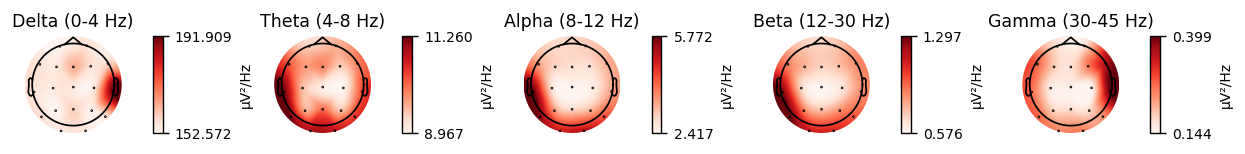

In [62]:
#a_raw[8].plot_psd(fmin=1., fmax=45.)
#matplotlib.use('Qt5Agg')
#c_raw[0][0].plot_psd_topomap(ch_type='eeg',fmin=0.5, fmax=45., normalize=False)


## Segmentation of raw EEG data

In [5]:
print("C duration mean")
print(np.mean(c_duration))
print("A duration mean")
print(np.mean(a_duration))

train_data_s,train_labels_s=segmentation(train_data, train_labels, segment_duration=20)

C duration mean
831.3442068965514
A duration mean
809.2474444444446
<RawEEGLAB | sub-039_task-eyesclosed_eeg.set, 19 x 425040 (850.1 s), ~61.6 MB, data loaded>
850.0
<RawEEGLAB | sub-046_task-eyesclosed_eeg.set, 19 x 376520 (753.0 s), ~54.6 MB, data loaded>
750.0
<RawEEGLAB | sub-063_task-eyesclosed_eeg.set, 19 x 402470 (804.9 s), ~58.4 MB, data loaded>
800.0
<RawEEGLAB | sub-044_task-eyesclosed_eeg.set, 19 x 440800 (881.6 s), ~63.9 MB, data loaded>
880.0
<RawEEGLAB | sub-064_task-eyesclosed_eeg.set, 19 x 424050 (848.1 s), ~61.5 MB, data loaded>
840.0
<RawEEGLAB | sub-061_task-eyesclosed_eeg.set, 19 x 401640 (803.3 s), ~58.2 MB, data loaded>
800.0
<RawEEGLAB | sub-038_task-eyesclosed_eeg.set, 19 x 445700 (891.4 s), ~64.6 MB, data loaded>
890.0
<RawEEGLAB | sub-058_task-eyesclosed_eeg.set, 19 x 378390 (756.8 s), ~54.9 MB, data loaded>
750.0
<RawEEGLAB | sub-060_task-eyesclosed_eeg.set, 19 x 374240 (748.5 s), ~54.3 MB, data loaded>
740.0
<RawEEGLAB | sub-065_task-eyesclosed_eeg.set, 19 x

In [6]:
print(len(train_labels_s))
#train_data_ob = np.array(train_data_s, dtype=object)
for a in train_data_s:
    print(a.shape)
   


65
(84, 19, 10001)
(74, 19, 10001)
(79, 19, 10001)
(87, 19, 10001)
(83, 19, 10001)
(79, 19, 10001)
(88, 19, 10001)
(74, 19, 10001)
(73, 19, 10001)
(87, 19, 10001)
(78, 19, 10001)
(78, 19, 10001)
(80, 19, 10001)
(97, 19, 10001)
(77, 19, 10001)
(77, 19, 10001)
(84, 19, 10001)
(74, 19, 10001)
(75, 19, 10001)
(95, 19, 10001)
(81, 19, 10001)
(79, 19, 10001)
(95, 19, 10001)
(87, 19, 10001)
(80, 19, 10001)
(88, 19, 10001)
(77, 19, 10001)
(76, 19, 10001)
(82, 19, 10001)
(72, 19, 10001)
(87, 19, 10001)
(58, 19, 10001)
(75, 19, 10001)
(69, 19, 10001)
(75, 19, 10001)
(78, 19, 10001)
(80, 19, 10001)
(89, 19, 10001)
(67, 19, 10001)
(29, 19, 10001)
(82, 19, 10001)
(60, 19, 10001)
(85, 19, 10001)
(78, 19, 10001)
(90, 19, 10001)
(114, 19, 10001)
(74, 19, 10001)
(69, 19, 10001)
(83, 19, 10001)
(82, 19, 10001)
(92, 19, 10001)
(88, 19, 10001)
(81, 19, 10001)
(95, 19, 10001)
(127, 19, 10001)
(62, 19, 10001)
(83, 19, 10001)
(96, 19, 10001)
(81, 19, 10001)
(78, 19, 10001)
(91, 19, 10001)
(83, 19, 10001)
(79

0.0


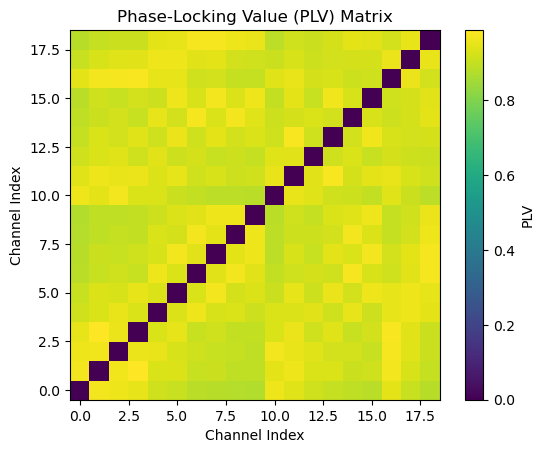

In [7]:
import numpy as np

def calculate_plv(data, sampling_rate=500):
    """
    Calculate Phase-Locking Value (PLV) for connectivity between 19 channels.

    Parameters:
    - data: 2D numpy array with shape (n_channels, n_samples)
    - sampling_rate: Sampling rate of the time series data

    Returns:
    - plv_matrix: 2D numpy array representing PLV between all pairs of channels
    """

    n_channels, n_samples = data.shape

    # Frequency calculation
    frequencies = np.fft.fftfreq(n_samples, d=1/sampling_rate)

    # Initialize PLV matrix
    plv_matrix = np.zeros((n_channels, n_channels))

    # Calculate PLV for each pair of channels
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            # Compute Fourier transform for both channels
            fourier_i = np.fft.fft(data[i, :])
            fourier_j = np.fft.fft(data[j, :])

            # Compute phase difference
            phase_diff = np.angle(fourier_i / fourier_j)

            # Compute PLV
            plv = np.abs(np.mean(np.exp(1j * phase_diff)))

            # Store PLV in the matrix
            plv_matrix[i, j] = plv
            plv_matrix[j, i] = plv  # PLV is symmetric

    return plv_matrix

def calculate_cc(data, sampling_rate=500):
    """
    Calculate Cross-Spectral Density (CSD) for connectivity between 19 channels.

    Parameters:
    - data: 2D numpy array with shape (n_channels, n_samples)
    - sampling_rate: Sampling rate of the time series data

    Returns:
    - csd_matrix: 2D numpy array representing CSD between all pairs of channels
    """

    n_channels, n_samples = data.shape

    # Frequency calculation
    frequencies = np.fft.fftfreq(n_samples, d=1/sampling_rate)

    # Initialize CSD matrix
    csd_matrix = np.zeros((n_channels, n_channels), dtype=complex)

    # Calculate CSD for each pair of channels
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            # Compute Fourier transforms for both channels
            fourier_i = np.fft.fft(data[i, :])
            fourier_j = np.fft.fft(data[j, :])

            # Compute CSD
            csd = abs(np.mean(fourier_i * np.conj(fourier_j)))
            print(csd)

            # Store CSD in the matrix
            csd_matrix[i, j] = csd
            csd_matrix[j, i] = np.conj(csd)  # CSD is Hermitian symmetric

    return csd_matrix







def plot_plv_matrix(plv_matrix):
    """
    Plot PLV matrix as a heatmap.

    Parameters:
    - plv_matrix: 2D numpy array representing PLV between all pairs of channels
    """

    plt.imshow(plv_matrix, cmap='viridis', origin='lower')
    plt.colorbar(label='PLV')
    plt.title('Phase-Locking Value (PLV) Matrix')
    plt.xlabel('Channel Index')
    plt.ylabel('Channel Index')
    plt.show()
# Example usage:
# Assuming 'your_data' is a 2D array with shape (19, 10001) and 'your_sampling_rate' is the sampling rate
index9=10


print(train_labels_s[index9][0])

#plv_result = calculate_plv(train_data_s[index9][0])
plv_result = calculate_plv(train_data_s[index9][0])
plot_plv_matrix(plv_result)
average_plv = np.mean(plv_result, axis=1)

#plt.plot(average_plv, label=f'Index {index9}')




## RBP Welsch explained 

0.0


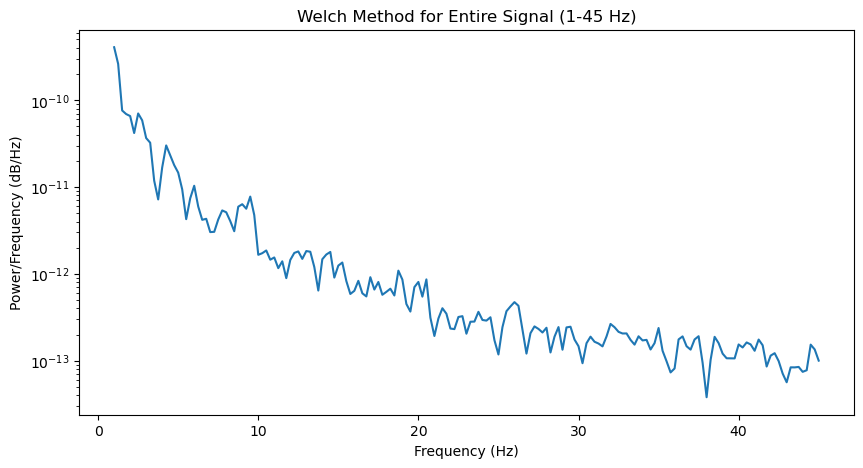

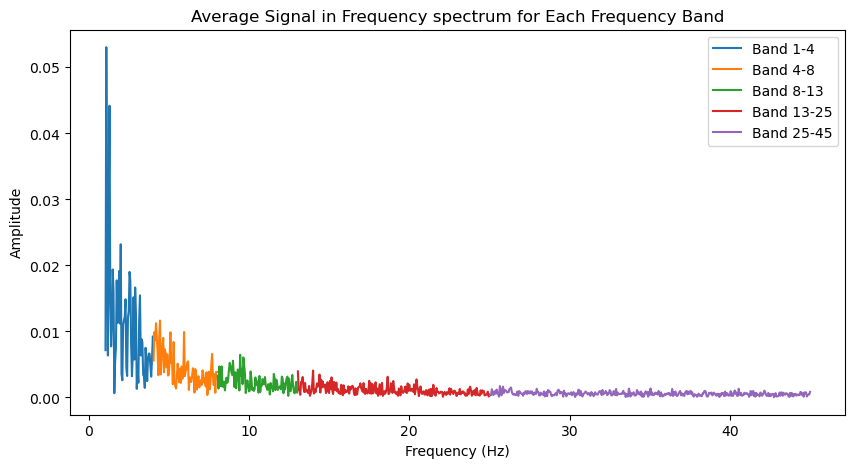

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def fourier_transform(signal, fs):
    # Perform Fourier Transform
    n = len(signal)
    fft_result = np.fft.fft(signal)
    freq = np.fft.fftfreq(n, 1/fs)
    
    return freq, fft_result

def welch_method(signal, fs):
    # Calculate power spectral density (PSD) using Welch method
    freqs, psd = welch(signal, fs=fs, nperseg=fs*4, noverlap=fs*2)
    
    return freqs, psd

def visualize_fourier_welch(epoch_data, fs):
    # Plot Fourier Transform for the entire signal (constrained to 1-45 Hz)
  
    
    avg_channel_signal = np.mean(epoch_data, axis=0)  # Calculate the average across all channels
   
    # Plot Welch method for the entire signal (constrained to 1-45 Hz)
    plt.figure(figsize=(10, 5))
    plt.title('Welch Method for Entire Signal (1-45 Hz)')
    
    avg_channel_signal = np.mean(epoch_data, axis=0)  # Calculate the average across all channels
    freqs, psd = welch_method(avg_channel_signal, fs)
    
    # Select frequency range
    freq_range = (freqs >= 1) & (freqs <= 45)
    
    plt.semilogy(freqs[freq_range], psd[freq_range])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.show()

    # Plot the average time series signal for each frequency band
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]

    plt.figure(figsize=(10, 5))
    plt.title('Average Signal in Frequency spectrum for Each Frequency Band')
    
    for band in frequency_bands:
        start_freq, end_freq = band

        # Fourier Transform
        freq, fft_result = fourier_transform(avg_channel_signal, fs)
        
        # Select frequency range
        freq_range = (freq >= start_freq) & (freq <= end_freq)
        
        # Plot average signal in time series for the selected frequency band
        plt.plot(freq[freq_range], np.abs(fft_result[freq_range]), label=f'Band {start_freq}-{end_freq}')
            
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Example usage
fs = 500
subject_index = 5
print(train_labels_s[subject_index][0])

visualize_fourier_welch(train_data_s[subject_index][0], fs)




## Extraction of Relative Band Power feature (RBP)

In [8]:
#!pip install mne_connectivity
import numpy as np
from scipy.signal import welch
from mne_connectivity import SpectralConnectivity
from mne_connectivity import spectral_connectivity_epochs
from sklearn.preprocessing import MinMaxScaler
from antropy import spectral_entropy as spectral_antropy # Assuming you have a method to compute spectral entropy



fs=500

def calculate_rbp(epoch, fs):
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    rbp_features = []
    #epoch_data=epoch.get_data()
    epoch_data=epoch
    
    for channel in epoch_data:
        # Calculate power spectral density (PSD) using Welch method
        freqs, psd = welch(channel, fs=fs, nperseg=fs*4, noverlap=fs*2)
        
        freq_idx_total = np.where((freqs >= 1) & (freqs <= 45))[0]
        
        total_psd = np.trapz(psd[freq_idx_total], axis=0)  # Sum across frequency bins
        
        rbp = []
        
        for band in frequency_bands:
            start_freq, end_freq = band
            freq_idx = np.where((freqs >= start_freq) & (freqs <= end_freq))[0]
            
            band_psd = np.trapz(psd[freq_idx], axis=0)  # Sum across selected frequency bins
            band_rbp = band_psd / total_psd
            rbp.append(band_rbp)
        
        rbp_features.append(rbp)
       
        
    rbp_features=np.array(rbp_features)
  
    rbp2d = rbp_features.reshape((19, 5, 1))
    
    return rbp_features,rbp2d

from scipy.signal import welch
import nolds


fs = 500

def calculate_rbp3(epoch, fs):
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    rbp_features = []
    se_features = []
    
    epoch_data = epoch
    
    for i, channel_i in enumerate(epoch_data):
        # Calculate power spectral density (PSD) using Welch method
        freqs, psd = welch(channel_i, fs=fs, nperseg=fs*4, noverlap=fs*2)
        
        freq_idx_total = np.where((freqs >= 1) & (freqs <= 45))[0]
        
        total_psd = np.trapz(psd[freq_idx_total], axis=0)  # Sum across frequency bins
        
        rbp = []
        subject_entropy = spectral_antropy(channel_i, sf=fs, nperseg=fs*4, method='welch', normalize=True)
        se_features.append(subject_entropy)
        
        for band in frequency_bands:
            start_freq, end_freq = band
            freq_idx = np.where((freqs >= start_freq) & (freqs <= end_freq))[0]
            
            band_psd = np.trapz(psd[freq_idx], axis=0)  # Sum across selected frequency bins
            band_rbp = band_psd / total_psd
            rbp.append(band_rbp)
        
        rbp_features.append(rbp)

        
    rbp_features = np.array(rbp_features)
    se_features = np.array(se_features)
    
    #print(rbp_features.shape) 
    #print(se_features.shape)
    
    se_features = se_features.reshape(-1, 1)
    
    plv=calculate_plv(epoch_data, 500)

    # Concatenate along the second axis
    concatenated_features = np.concatenate((rbp_features, se_features,plv), axis=1)
    
    #print(concatenated_features.shape)
   
    #print(concatenated_features.shape)
    concatenated_2d = concatenated_features.reshape((19, 25, 1))
    
    return concatenated_features, concatenated_2d





def calculate_rbp3(epoch, fs):
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    rbp_features = []
    #epoch_data=epoch.get_data()
    epoch_data=epoch
    
    for channel in epoch_data:
        # Calculate power spectral density (PSD) using Welch method
        freqs, psd = welch(channel, fs=fs, nperseg=fs*4, noverlap=fs*2)
        
        freq_idx_total = np.where((freqs >= 1) & (freqs <= 45))[0]
        
        total_psd = np.trapz(psd[freq_idx_total], axis=0)  # Sum across frequency bins
        
        rbp = []
        
        for i, band in enumerate(frequency_bands):
            start_freq, end_freq = band
            freq_idx = np.where((freqs >= start_freq) & (freqs <= end_freq))[0]
            
            band_psd = np.trapz(psd[freq_idx], axis=0)  # Sum across selected frequency bins
            band_rbp = band_psd / total_psd
            
            # Scale bands 2 to 5 by 5x multiplier
            if i > 0:
                band_rbp *= 5
            
            rbp.append(band_rbp)
        
        rbp_features.append(rbp)
        
    rbp_features = np.array(rbp_features)
    reshaped_array = np.transpose(rbp_features, (1, 0))
    rbp2d = rbp_features.reshape((19, 5, 1))  # Adjust the shape according to your requirements
    
    return rbp_features, rbp2d



def calculate_rbp3(epoch, fs):
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]

    rbp_features = []
    epoch_data = epoch
    spectral_entropy_features = []
    
    for channel in epoch_data:
        # Calculate power spectral density (PSD) using Welch method
        freqs, psd = welch(channel, fs=fs, nperseg=fs*4, noverlap=fs*2)

        freq_idx_total = np.where((freqs >= 1) & (freqs <= 45))[0]
        total_psd = np.trapz(psd[freq_idx_total], axis=0)  # Sum across frequency bins

        rbp = []

        subject_entropy = spectral_antropy(channel, sf=fs, nperseg=fs*4, method='welch', normalize=True)
        spectral_entropy_features.append(subject_entropy)

        for i, band in enumerate(frequency_bands):
            start_freq, end_freq = band
            freq_idx = np.where((freqs >= start_freq) & (freqs <= end_freq))[0]
            band_psd = np.trapz(psd[freq_idx], axis=0)  # Sum across selected frequency bins
            band_rbp = band_psd / total_psd

            rbp.append(band_rbp)

        rbp_features.append(rbp)

    # Convert lists to numpy arrays
    se = np.array(spectral_entropy_features)
    rbp_features = np.array(rbp_features)

    # Apply Min-Max scaling separately to each band and spectral entropy
    scaler = MinMaxScaler()
    scaled_rbp_features = []
    for band_idx in range(rbp_features.shape[1]):
        band_data = rbp_features[:, band_idx]
        band_data_scaled = scaler.fit_transform(band_data.reshape(-1, 1)).flatten()
        scaled_rbp_features.append(band_data_scaled)
    scaled_rbp_features = np.array(scaled_rbp_features).T

    scaled_se = scaler.fit_transform(se.reshape(-1, 1)).flatten()

    # Concatenate scaled features and reshape for the desired format
    concatenated_features = np.concatenate((scaled_rbp_features, scaled_se[:, np.newaxis]), axis=1)
    rbp2d = concatenated_features.reshape((19, 6, 1))

    return concatenated_features, rbp2d




# Initialize an empty list to store RBP features for all epochs

rbp_features_all_subjects = []
rbp2d_features_all_subjects = []


# Loop through each EEG epoch in train_data

for subject in train_data_s:
    rbp_features_all_segments = []
    rbp2d_features_all_segments = []
    print(subject.shape)
    for segment in subject:
        
        # Calculate RBP features for the current epoch
        rbp_features,rbp2d_features = calculate_rbp(segment, fs)
        #rbp_features = calculate_rbp_filter(segment, fs)
        rbp_features_all_segments.append(rbp_features)
        rbp2d_features_all_segments.append(rbp2d_features)
    
    rbp_features_all_subjects.append(np.array(rbp_features_all_segments))
    rbp2d_features_all_subjects.append(np.array(rbp2d_features_all_segments))




(84, 19, 10001)
(74, 19, 10001)
(79, 19, 10001)
(87, 19, 10001)
(83, 19, 10001)
(79, 19, 10001)
(88, 19, 10001)
(74, 19, 10001)
(73, 19, 10001)
(87, 19, 10001)
(78, 19, 10001)
(78, 19, 10001)
(80, 19, 10001)
(97, 19, 10001)
(77, 19, 10001)
(77, 19, 10001)
(84, 19, 10001)
(74, 19, 10001)
(75, 19, 10001)
(95, 19, 10001)
(81, 19, 10001)
(79, 19, 10001)
(95, 19, 10001)
(87, 19, 10001)
(80, 19, 10001)
(88, 19, 10001)
(77, 19, 10001)
(76, 19, 10001)
(82, 19, 10001)
(72, 19, 10001)
(87, 19, 10001)
(58, 19, 10001)
(75, 19, 10001)
(69, 19, 10001)
(75, 19, 10001)
(78, 19, 10001)
(80, 19, 10001)
(89, 19, 10001)
(67, 19, 10001)
(29, 19, 10001)
(82, 19, 10001)
(60, 19, 10001)
(85, 19, 10001)
(78, 19, 10001)
(90, 19, 10001)
(114, 19, 10001)
(74, 19, 10001)
(69, 19, 10001)
(83, 19, 10001)
(82, 19, 10001)
(92, 19, 10001)
(88, 19, 10001)
(81, 19, 10001)
(95, 19, 10001)
(127, 19, 10001)
(62, 19, 10001)
(83, 19, 10001)
(96, 19, 10001)
(81, 19, 10001)
(78, 19, 10001)
(91, 19, 10001)
(83, 19, 10001)
(79, 1

In [8]:
print(rbp_features_all_segments)

[array([[0.68301238, 0.12109104, 0.05450694, 0.07153955, 0.06985009,
        0.03464791, 0.01093915],
       [0.6647734 , 0.1291471 , 0.06013579, 0.06990072, 0.07604298,
        0.37996046, 0.05291503],
       [0.69999213, 0.12901018, 0.0565731 , 0.06201098, 0.0524136 ,
        0.20993006, 0.        ],
       [0.67758963, 0.13839108, 0.05994439, 0.06406345, 0.06001144,
        0.56343359, 0.00708578],
       [0.74870217, 0.14192399, 0.04651847, 0.03700646, 0.0258489 ,
        0.33428581, 0.03035596],
       [0.73518913, 0.1497879 , 0.04415938, 0.04126163, 0.02960196,
        0.64065902, 0.06776259],
       [0.654432  , 0.13002756, 0.14660976, 0.04519257, 0.02373812,
        0.6490069 , 0.8640311 ],
       [0.70841671, 0.14528993, 0.07538531, 0.04801577, 0.02289228,
        0.66389195, 0.37963291],
       [0.47663853, 0.10229087, 0.35749833, 0.04438266, 0.0191896 ,
        0.57699262, 1.        ],
       [0.53482323, 0.11366964, 0.28014291, 0.04971094, 0.02165329,
        0.02629559, 0.

## Converting to tensors

In [10]:

# The shape of rbp_features_all_epochs is (number of epochs, number of frequency bands, number of channels)
for x in rbp_features_all_subjects:
    print("Shape of RBP features:", x.shape)
    #print("Shape of RBP features 2D:", y.shape)


raw_data = rbp_features_all_subjects[0]
print(raw_data.shape)  # This will show the shape of the EEG data

# Convert train_data and val_data to tensors of the same shape
train_data_rbp=rbp_features_all_subjects
train_data_rbp2d=rbp2d_features_all_subjects
#train_data_rbp = tf.convert_to_tensor(rbp_features_all_epochs, dtype=tf.float32)


train_labels.astype(int)
#train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)




Shape of RBP features: (84, 19, 5)
Shape of RBP features: (74, 19, 5)
Shape of RBP features: (79, 19, 5)
Shape of RBP features: (87, 19, 5)
Shape of RBP features: (83, 19, 5)
Shape of RBP features: (79, 19, 5)
Shape of RBP features: (88, 19, 5)
Shape of RBP features: (74, 19, 5)
Shape of RBP features: (73, 19, 5)
Shape of RBP features: (87, 19, 5)
Shape of RBP features: (78, 19, 5)
Shape of RBP features: (78, 19, 5)
Shape of RBP features: (80, 19, 5)
Shape of RBP features: (97, 19, 5)
Shape of RBP features: (77, 19, 5)
Shape of RBP features: (77, 19, 5)
Shape of RBP features: (84, 19, 5)
Shape of RBP features: (74, 19, 5)
Shape of RBP features: (75, 19, 5)
Shape of RBP features: (95, 19, 5)
Shape of RBP features: (81, 19, 5)
Shape of RBP features: (79, 19, 5)
Shape of RBP features: (95, 19, 5)
Shape of RBP features: (87, 19, 5)
Shape of RBP features: (80, 19, 5)
Shape of RBP features: (88, 19, 5)
Shape of RBP features: (77, 19, 5)
Shape of RBP features: (76, 19, 5)
Shape of RBP feature

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Visualisation of RBP feature 2D

## Model CNN 2D

In [18]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Add, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Model

def create_CNN2D_model(input_shape):
    # Input layer
    input_layer = Input(shape=input_shape)
    bn1 = BatchNormalization()(input_layer)
    
    conv1 = Conv2D(filters=4, kernel_size=(3, 2), activation='relu')(bn1)
    bn2 = BatchNormalization()(conv1)
    
    conv2 = Conv2D(filters=4, kernel_size=(3, 3), activation='relu',padding='same')(bn2)
    bn3= BatchNormalization()(conv2)
    
    #skip_connection = Add()([bn2, bn3])
    #bn4= BatchNormalization()(skip_connection)
    flatten = Flatten()(bn3)
    
    
    # Fully connected layers
    dense1 = Dense(8, activation='relu',kernel_initializer=HeNormal())(flatten)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(8, activation='relu',kernel_initializer=HeNormal())(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    output_layer = Dense(1, activation='sigmoid',kernel_initializer=GlorotNormal())(dropout2)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Example usage
input_shape = train_data_rbp2d[0][0].shape
model_CNN2D = create_CNN2D_model(input_shape)
model_CNN2D.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 19, 5, 1)]        0         
                                                                 
 batch_normalization_12 (Ba  (None, 19, 5, 1)          4         
 tchNormalization)                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 17, 4, 4)          28        
                                                                 
 batch_normalization_13 (Ba  (None, 17, 4, 4)          16        
 tchNormalization)                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 4, 4)          148       
                                                                 
 batch_normalization_14 (Ba  (None, 17, 4, 4)          16  

## Model RNN

## Model CNN 1D MULTI-HEAD

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Reshape,Lambda,SpatialDropout1D, Conv2D,SpatialDropout2D,Conv1D, Dropout,MaxPooling1D,DepthwiseConv1D,SeparableConv1D, AveragePooling1D, Flatten, BatchNormalization, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.initializers import HeNormal


def model_CNN_1D_multi_head_BUILD(input_shape):
    # Create the input layer
    input_layer = Input(shape=input_shape)

    sequence_length = input_shape[0]  
    #x = BatchNormalization()(input_layer)
    flat_x = Flatten()(input_layer)

    # Define the convolutional heads
    def convolutional_head(kernel_size,input_tensor):
        conv1 = Conv1D( filters=4,kernel_size=kernel_size, activation='relu')(input_tensor)
        bn1 = BatchNormalization()(conv1)
        #pool = MaxPooling1D(pool_size=2)(conv)  # Use AveragePooling1D instead of MaxPooling1D
        conv2 = Conv1D( filters=4,kernel_size=kernel_size, activation='relu',padding='same')(bn1)
        bn2 = BatchNormalization()(conv2)
        
        skip_connection = Add()([bn1, bn2])
        skip_connection1 = BatchNormalization()(skip_connection)
        #spatial_dropout=SpatialDropout1D(0.25)(pool)
        #conv2 = Conv1D(filters=4, kernel_size=kernel_size, activation='relu')(spatial_dropout)
        normalized_flat = Flatten()(skip_connection1)
        return normalized_flat
    
    

    def convolutional_head_2D(kernel_size, input_layer):
        input_tensor = Reshape((input_layer.shape.as_list()[1], input_layer.shape.as_list()[2], 1))(input_layer)
        # First Convolutional Layer with Batch Normalization and ReLU activation
        bn1 = BatchNormalization()(input_tensor)
    
        conv1 = Conv2D(filters=4, kernel_size=(3, 2), activation='relu')(bn1)
        bn2 = BatchNormalization()(conv1)

        conv2 = Conv2D(filters=4, kernel_size=(3, 3), activation='relu',padding='same')(bn2)
        bn3= BatchNormalization()(conv2)

        skip_connection = Add()([bn2, bn3])
        bn4= BatchNormalization()(skip_connection)
        flatten = Flatten()(bn4)

        return flatten


    #flat1 = convolutional_head(1)
    flat3 = convolutional_head(3,input_layer)
    #flat5 = convolutional_head(5,input_layer)
    #flat7 =  convolutional_head(7)
   
    
    flat2D_31=convolutional_head_2D((3,3),input_layer)

    # Concatenate the outputs of all convolutional heads
    #concatenated = Concatenate()([flat_x,flat_delta, flat_theta, flat_alpha, flat_beta, flat_gamma,flat3,flat5,flat2D_31])
    concatenated = Concatenate()([flat3,flat2D_31])
    
    normalized1 = BatchNormalization()(concatenated)
     # Add batch normalization, pooling, and dropout layers
    #dropout = Dropout(0.2)(concatenated)

  
    dense_layer3 = Dense(8, activation='relu')(normalized1)
    dropout4 = Dropout(0.5)(dense_layer3)
    dense_layer5 = Dense(8, activation='relu')(dropout4)
    dropout5 = Dropout(0.5)(dense_layer5)
    output_layer = Dense(1, activation='sigmoid')(dropout5)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model


# Define the input shape (adjust the 'input_shape' to match your data shape)
input_shape = train_data_rbp[0][0].shape 
print(input_shape)

# Create the model using the function
model_CNN_1D_multi_head = model_CNN_1D_multi_head_BUILD(input_shape)

# Print the model summary
model_CNN_1D_multi_head.summary()


(19, 5)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 19, 5)]              0         []                            
                                                                                                  
 reshape (Reshape)           (None, 19, 5, 1)             0         ['input_2[0][0]']             
                                                                                                  
 batch_normalization_7 (Bat  (None, 19, 5, 1)             4         ['reshape[0][0]']             
 chNormalization)                                                                                 
                                                                                                  
 conv1d (Conv1D)             (None, 17, 4)                64        ['input_2[0][0]'] 

In [30]:

import pydot

from IPython.display import display
from tensorflow.keras.utils import plot_model

# Visualize the model architecture in the Jupyter Notebook
plot_model(model_CNN2D, show_shapes=True, show_layer_names=True)

# Display the model diagram inline in the Jupyter Notebook
display()




You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Train data statistics

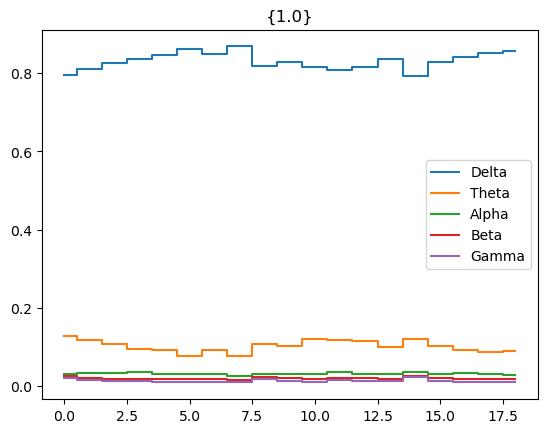

In [15]:
#print("train_data_rbp shape:", train_data_rbp.shape)
#print("train_data_rbp data type:", train_data_rbp.dtype)

#print("train_labels shape:", train_labels.shape)
#print("train_labels data type:", train_labels.dtype)
#print(train_labels_s)
#labelC1=0
#for t in train_labels:
#    if(t==0):
#        labelC1 += 1
        
#print(labelC1)
#print(train_data_rbp[0])
min_value = 30  # Minimum value for index3
max_value = 40  # Maximum value for index3
index3 = random.randint(min_value, max_value)
#print(train_labels[index3])
plt.step(range(len(train_data_rbp[index3][index3])), train_data_rbp[index3][index3], where='mid')
#plt.plot(train_data_rbp[index3])
plt.title({train_labels_s[index3][index3]})
plt.legend(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma','Entropy'])




0.0


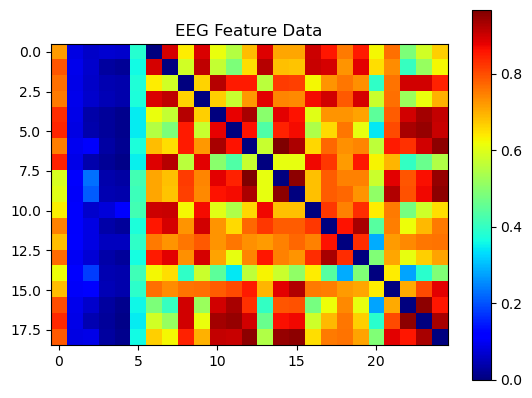

In [14]:
import numpy as np
import matplotlib.pyplot as plt

index3 = random.randint(min_value, max_value)
print(train_labels[index3])


# Reshape the data to (19, 5, 1)
train_data_rbp2D = train_data_rbp[index3][index3].reshape((19,25, 1))


# Plot the EEG data as an image
plt.imshow(train_data_rbp2D[:, :, 0], cmap='jet')  # You can choose a different colormap if needed
plt.title('EEG Feature Data')
plt.colorbar()
plt.show()

# Now, if you want to use this data as input to a CNN2D, you may need to further preprocess it based on your model's requirements.


## Model MLP training loop

In [52]:
from sklearn.model_selection import LeaveOneOut
import numpy as np
import tensorflow as tf
import random 
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.initializers import HeNormal


train_labels=train_labels_s

learning_rate = 0.005  # Learning rate for the optimizer
beta_1 = 0.9  # Exponential decay rate for the first moment estimates
beta_2 = 0.999  # Exponential decay rate for the second moment estimates
epsilon = 1e-7  # A small constant for numerical stability

ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="accuracy", factor=0.3, patience=4, verbose=1, mode="max", min_lr=0.00005)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",patience=10,verbose=1,mode="max",restore_best_weights=True)

optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
# Assuming train_data_rbp and train_labels are your python lists
# train_data_rbp: [num_subjects, num_epochs, num_channels, num_frequency_bands]
# train_labels: [num_subjects]

num_subjects = len(train_data_rbp)
num_channels = train_data_rbp[0][0].shape[0]
num_frequency_bands = train_data_rbp[0][0].shape[1]

loo = LeaveOneOut()

average_accuracy = []

confusion_true_MLP = []
confusion_pred_MLP = []

histories_MLP=[]

for subject_idx in range(num_subjects):
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")

    tf.keras.backend.clear_session()
    model_MLP = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(num_channels, num_frequency_bands)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4, activation='relu', kernel_initializer=HeNormal()),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation='relu', kernel_initializer=HeNormal()),
        tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=GlorotNormal()) 
    ])

    
    optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    model_MLP.compile(optimizer=optimizer_ADAM, loss='binary_crossentropy', metrics=['accuracy'])

    train_data = []
    train_labels_concat = []

    # Construct the training set excluding current subject's epochs
    for idx, data in enumerate(train_data_rbp):
        if idx != subject_idx:
            # Shuffle the indices for data and corresponding labels
            shuffled_indices = list(range(len(data)))
            random.shuffle(shuffled_indices)
            for shuffled_idx in shuffled_indices:
                train_data.extend(data[shuffled_idx])
                # Convert the label to a list before extending
                train_labels_concat.extend([train_labels[idx][shuffled_idx]])
                
    # Reshape the training data to match the model's input shape
    train_data_reshaped = np.array(train_data).reshape(-1, num_channels, num_frequency_bands)

    # Train the model
    history_MLP = model_MLP.fit(train_data_reshaped, np.array(train_labels_concat),
                                epochs=20, batch_size=32, verbose=1, callbacks=[EarlyStop, ReduceLR])
    histories_MLP.append(history_MLP)

    # Test on the current subject's epochs
    test_data = np.array(train_data_rbp[subject_idx]).reshape(-1, num_channels, num_frequency_bands)
    test_labels_concat = np.array(train_labels[subject_idx])

    # Predict on test data
    test_pred = model_MLP.predict(test_data)

    # Convert prediction to binary (0 or 1) based on a threshold (0.5 for example)
    threshold = 0.5
    test_pred_binary = (test_pred > threshold).astype(int)

    # Calculate accuracy manually
    test_acc = np.mean(test_pred_binary == test_labels_concat)

    print(f"Test Accuracy: {test_acc:.4f}")
    print("=" * 30)

    average_accuracy.append(test_acc)

    confusion_true_MLP.extend(test_labels_concat)
    confusion_pred_MLP.extend(test_pred_binary.flatten())

average_accuracy = np.mean(average_accuracy)
print(f"Average Test Accuracy: {average_accuracy:.4f}")
print("Leave-One-Subject-Out validation complete.")


Leave-One-Subject-Out: Testing on subject 1/65
Epoch 1/20
161/161 [==============================] - 7s 3ms/step - loss: 0.5727 - accuracy: 0.7509 - lr: 0.0050
Epoch 2/20
161/161 [==============================] - 0s 3ms/step - loss: 0.4619 - accuracy: 0.8171 - lr: 0.0050
Epoch 3/20
161/161 [==============================] - 0s 3ms/step - loss: 0.3976 - accuracy: 0.8406 - lr: 0.0050
Epoch 4/20
161/161 [==============================] - 0s 3ms/step - loss: 0.3400 - accuracy: 0.8615 - lr: 0.0050
Epoch 5/20
161/161 [==============================] - 1s 3ms/step - loss: 0.3358 - accuracy: 0.8615 - lr: 0.0050
Epoch 6/20
161/161 [==============================] - 1s 3ms/step - loss: 0.3269 - accuracy: 0.8618 - lr: 0.0050
Epoch 7/20
161/161 [==============================] - 0s 3ms/step - loss: 0.3084 - accuracy: 0.8751 - lr: 0.0050
Epoch 8/20
161/161 [==============================] - 0s 3ms/step - loss: 0.2984 - accuracy: 0.8762 - lr: 0.0050
Epoch 9/20
161/161 [=============================

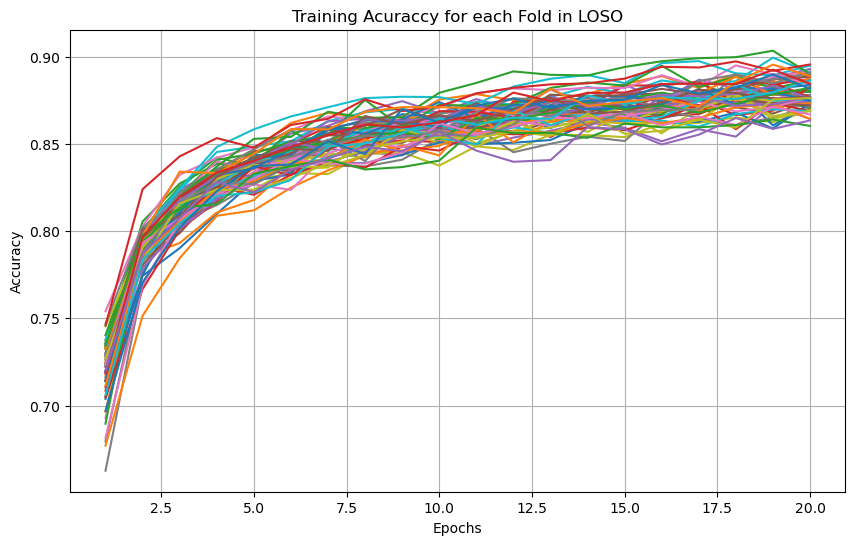

In [16]:
plot_accuracy(histories_MLP)

Accuracy: 0.7342643964032906
Precision: 0.7505112474437627
Sensitivity (Recall): 0.770199370409234
Specificity: 0.6908783783783784
F1-score: 0.7602278612118073


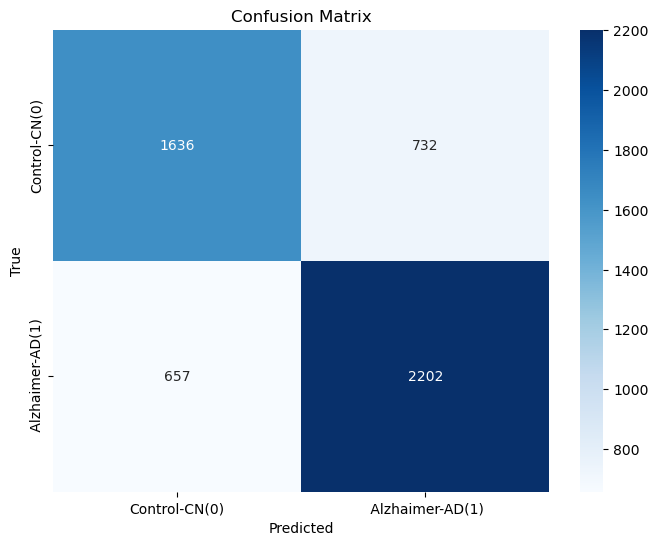

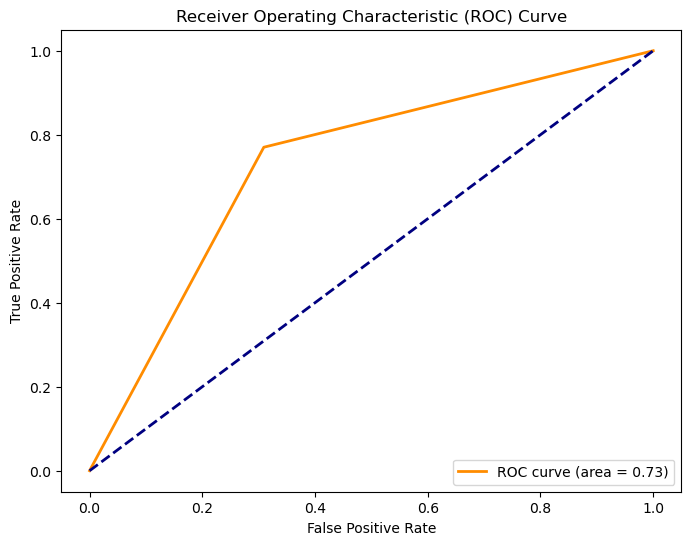

In [53]:

calculate_metrics_and_plot(confusion_true_MLP, confusion_pred_MLP)

## Model CNN 1D MULTI-HEAD  training loop

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix

train_labels=train_labels_s

learning_rate = 0.005  # Learning rate for the optimizer
beta_1 = 0.9  # Exponential decay rate for the first moment estimates
beta_2 = 0.999  # Exponential decay rate for the second moment estimates
epsilon = 1e-7  # A small constant for numerical stability

ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="accuracy", factor=0.3, patience=4, verbose=1, mode="max", min_lr=0.00005)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",patience=10,verbose=1,mode="max",restore_best_weights=True)

optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
# Assuming train_data_rbp and train_labels are your python lists
# train_data_rbp: [num_subjects, num_epochs, num_channels, num_frequency_bands]
# train_labels: [num_subjects]

num_subjects = len(train_data_rbp)
num_epochs = train_data_rbp[0].shape[0]
num_channels = train_data_rbp[0].shape[1]
num_frequency_bands = train_data_rbp[0].shape[2]

loo = LeaveOneOut()

average_accuracy = []
confusion_true_CNN = []
confusion_pred_CNN = []
histories_CNN = []

for subject_idx in range(num_subjects):
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")

    tf.keras.backend.clear_session()
    model_CNN_1D_multi_head = model_CNN_1D_multi_head_BUILD((num_channels, num_frequency_bands))
    optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    model_CNN_1D_multi_head.compile(optimizer=optimizer_ADAM, loss='binary_crossentropy', metrics=['accuracy'])

    # Separate current subject's data for testing
    test_data = np.array(train_data_rbp[subject_idx])
    test_labels_concat = np.array(train_labels[subject_idx])

    # Combine data from other subjects for training
    train_data = []
    train_labels_concat = []
    for idx, data in enumerate(train_data_rbp):
        if idx != subject_idx:
            train_data.extend(data)
            train_labels_concat.extend(train_labels[idx])

    # Reshape the training data to match the model's input shape
    train_data_reshaped = np.array(train_data).reshape(-1, num_channels, num_frequency_bands)

    # Train the model
    history_CNN = model_CNN_1D_multi_head.fit(train_data_reshaped, np.array(train_labels_concat),
                                             epochs=15, batch_size=16, verbose=1, callbacks=[EarlyStop, ReduceLR])
    histories_CNN.append(history_CNN)

    # Predict on test data
    test_pred = model_CNN_1D_multi_head.predict(test_data)

    # Convert prediction to binary (0 or 1) based on a threshold (0.5 for example)
    threshold = 0.5
    test_pred_binary = (test_pred > threshold).astype(int)

    # Calculate accuracy and confusion matrix
    test_acc = accuracy_score(test_labels_concat, test_pred_binary)
    confusion_true_CNN.extend(test_labels_concat)
    confusion_pred_CNN.extend(test_pred_binary.flatten())

    print(f"Test Accuracy: {test_acc:.4f}")
    print("=" * 30)

    average_accuracy.append(test_acc)

average_accuracy = np.mean(average_accuracy)
print(f"Average Test Accuracy: {average_accuracy:.4f}")
print("Leave-One-Subject-Out validation complete.")

# Calculate and print confusion matrix
#confusion_matrix_CNN = confusion_matrix(confusion_true_CNN, confusion_pred_CNN)
#print("Confusion Matrix:")
#print(confusion_matrix_CNN)



Leave-One-Subject-Out: Testing on subject 1/65
Epoch 1/15
322/322 [==============================] - 13s 6ms/step - loss: 0.6113 - accuracy: 0.7034 - lr: 0.0050
Epoch 2/15
322/322 [==============================] - 2s 6ms/step - loss: 0.5175 - accuracy: 0.7577 - lr: 0.0050
Epoch 3/15
322/322 [==============================] - 2s 6ms/step - loss: 0.4740 - accuracy: 0.7871 - lr: 0.0050
Epoch 4/15
322/322 [==============================] - 2s 6ms/step - loss: 0.4639 - accuracy: 0.7935 - lr: 0.0050
Epoch 5/15
322/322 [==============================] - 2s 6ms/step - loss: 0.4502 - accuracy: 0.7945 - lr: 0.0050
Epoch 6/15
322/322 [==============================] - 3s 9ms/step - loss: 0.4288 - accuracy: 0.8229 - lr: 0.0050
Epoch 7/15
322/322 [==============================] - 3s 10ms/step - loss: 0.3999 - accuracy: 0.8352 - lr: 0.0050
Epoch 8/15
322/322 [==============================] - 3s 9ms/step - loss: 0.4274 - accuracy: 0.8179 - lr: 0.0050
Epoch 9/15
322/322 [===========================

In [19]:
calculate_metrics_and_plot(confusion_true_CNN, confusion_pred_CNN)

NameError: name 'confusion_true_CNN' is not defined

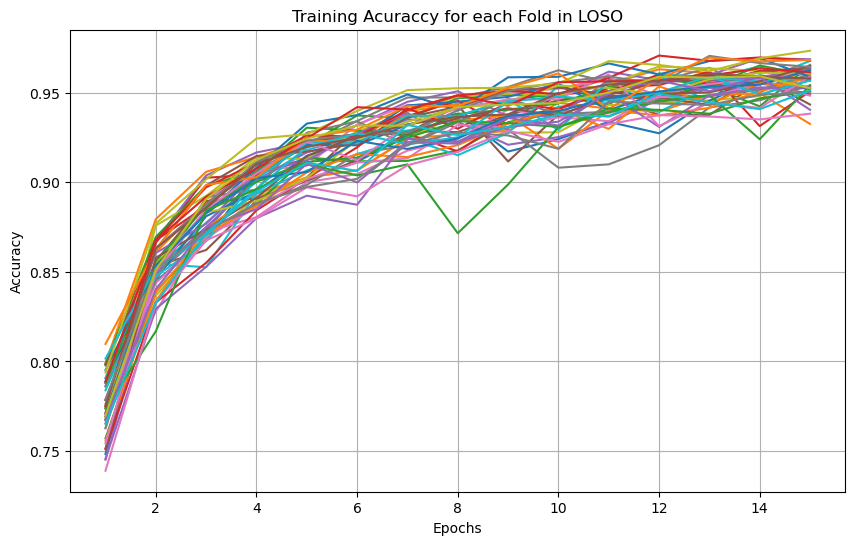

In [26]:
plot_accuracy(histories_CNN)

## Model CNN 2D training loop

In [102]:
print(train_data_rbp2d[0][0].shape)

(19, 10, 1)


In [20]:
from sklearn.model_selection import LeaveOneOut
import numpy as np
import tensorflow as tf
import random

train_labels=train_labels_s

num_subjects = len(train_data_rbp)
num_epochs = train_data_rbp[0].shape[0]
num_channels = train_data_rbp[0].shape[1]
num_frequency_bands = train_data_rbp[0].shape[2]


learning_rate = 0.005  # Learning rate for the optimizer
beta_1 = 0.9  # Exponential decay rate for the first moment estimates
beta_2 = 0.999  # Exponential decay rate for the second moment estimates
epsilon = 1e-7  # A small constant for numerical stability

ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="accuracy", factor=0.3, patience=4, verbose=1, mode="max", min_lr=0.00005)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",patience=10,verbose=1,mode="max",restore_best_weights=True)

optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
# ... (Assume train_data_rbp2d, train_labels, learning_rate, beta_1, beta_2, epsilon, ReduceLR, EarlyStop are defined)

num_subjects = len(train_data_rbp2d)

loo = LeaveOneOut()

average_accuracy = []

confusion_true_CNN2D = []
confusion_pred_CNN2D = []  # Changed from confusion_pred_MLP

histories_CNN2D = []  # Changed from histories_MLP

for subject_idx in range(num_subjects):
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")

    tf.keras.backend.clear_session()

    # Define the CNN2D model
       # Assuming input_shape is the shape of your input data
    input_shape = train_data_rbp2d[0][0].shape

    model_CNN2D=create_CNN2D_model(input_shape)
    optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    model_CNN2D.compile(optimizer=optimizer_ADAM, loss='binary_crossentropy', metrics=['accuracy'])
    
    train_data_concat = []
    train_labels_concat = []
    # Construct the training set excluding current subject's data
    for idx, data in enumerate(train_data_rbp2d):
        if idx != subject_idx:
            # Concatenate data along the first axis (axis=0)
            train_data_concat.extend(data)
            # Concatenate labels
            train_labels_concat.extend(train_labels[idx])

    # Concatenate the lists of arrays to create final numpy arrays
    
    #train_data_concatenated = np.concatenate(train_data_concat, axis=0)
    #train_data_concatenated=np.array(train_data_concat)
    train_labels_concatenated = np.array(train_labels_concat)

    # Reshape the training data to match the model's input shape
    #train_data_reshaped = train_data_concatenated.reshape(-1, num_channels, num_frequency_bands, 1)
    train_data_reshaped = np.array(train_data_concat).reshape(-1, num_channels, num_frequency_bands,1)
    # Train the CNN2D model
    history_CNN2D = model_CNN2D.fit(train_data_reshaped, train_labels_concatenated,
                                     epochs=20, batch_size=32, verbose=1, callbacks=[EarlyStop, ReduceLR])

    histories_CNN2D.append(history_CNN2D)

    # Test on the current subject's data
    test_data = np.array(train_data_rbp2d[subject_idx])
    test_labels = np.array(train_labels[subject_idx])

    # Predict using the CNN2D model
    test_pred = model_CNN2D.predict(test_data)

    # Convert predictions to binary (0 or 1) based on a threshold (0.5 for example)
    threshold = 0.5
    test_pred_binary = (test_pred > threshold).astype(int)

    # Calculate accuracy manually
    test_acc = np.mean(test_pred_binary.flatten() == test_labels)

    print(f"Test Accuracy: {test_acc:.4f}")
    print("=" * 30)

    average_accuracy.append(test_acc)

    confusion_true_CNN2D.extend(test_labels)  # Changed from confusion_true_MLP
    confusion_pred_CNN2D.extend(test_pred_binary.flatten())  # Changed from confusion_pred_MLP

average_accuracy = np.mean(average_accuracy)
print(f"Average Test Accuracy: {average_accuracy:.4f}")
print("Leave-One-Subject-Out validation complete.")


Leave-One-Subject-Out: Testing on subject 1/65
Epoch 1/20
161/161 [==============================] - 3s 5ms/step - loss: 0.4660 - accuracy: 0.7875 - lr: 0.0050
Epoch 2/20
161/161 [==============================] - 1s 6ms/step - loss: 0.3694 - accuracy: 0.8347 - lr: 0.0050
Epoch 3/20
161/161 [==============================] - 1s 6ms/step - loss: 0.3152 - accuracy: 0.8649 - lr: 0.0050
Epoch 4/20
161/161 [==============================] - 1s 5ms/step - loss: 0.2920 - accuracy: 0.8738 - lr: 0.0050
Epoch 5/20
161/161 [==============================] - 1s 5ms/step - loss: 0.2715 - accuracy: 0.8806 - lr: 0.0050
Epoch 6/20
161/161 [==============================] - 1s 6ms/step - loss: 0.2767 - accuracy: 0.8808 - lr: 0.0050
Epoch 7/20
161/161 [==============================] - 1s 7ms/step - loss: 0.2462 - accuracy: 0.8989 - lr: 0.0050
Epoch 8/20
161/161 [==============================] - 1s 7ms/step - loss: 0.2366 - accuracy: 0.9069 - lr: 0.0050
Epoch 9/20
161/161 [=============================

Accuracy: 0.7466998278171035
Precision: 0.7606112054329371
Sensitivity (Recall): 0.7834907310248339
Specificity: 0.7022804054054054
F1-score: 0.771881461061337


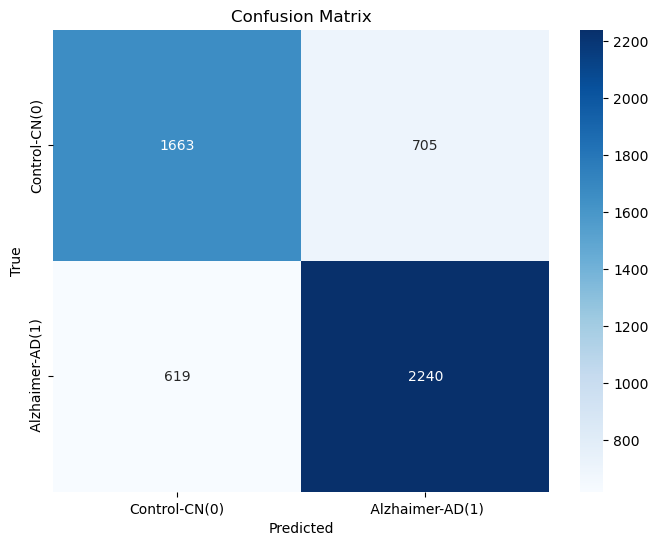

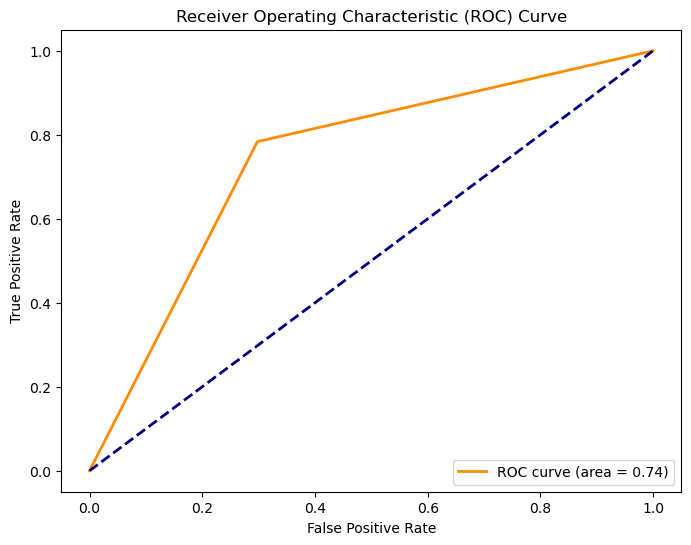

In [21]:
calculate_metrics_and_plot(confusion_true_CNN2D, confusion_pred_CNN2D)

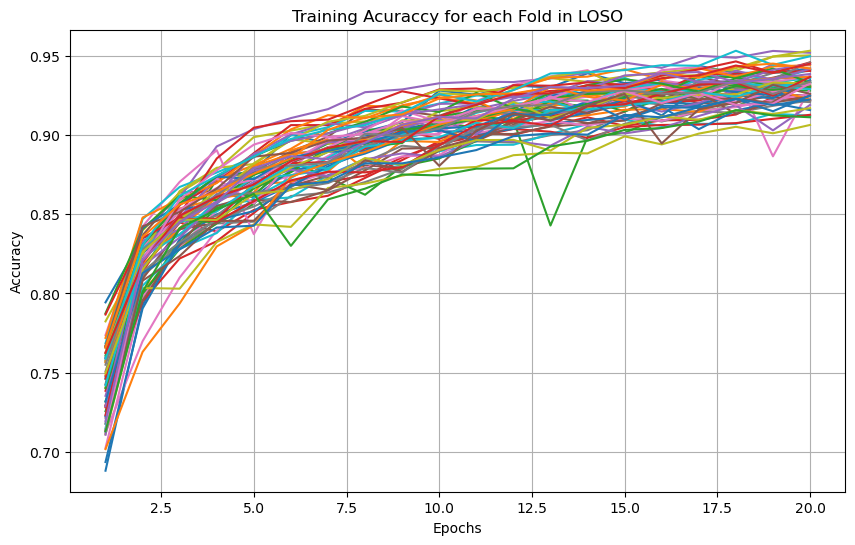

In [63]:
plot_accuracy(histories_CNN2D)


1/1 [==============================] - 0s 33ms/step


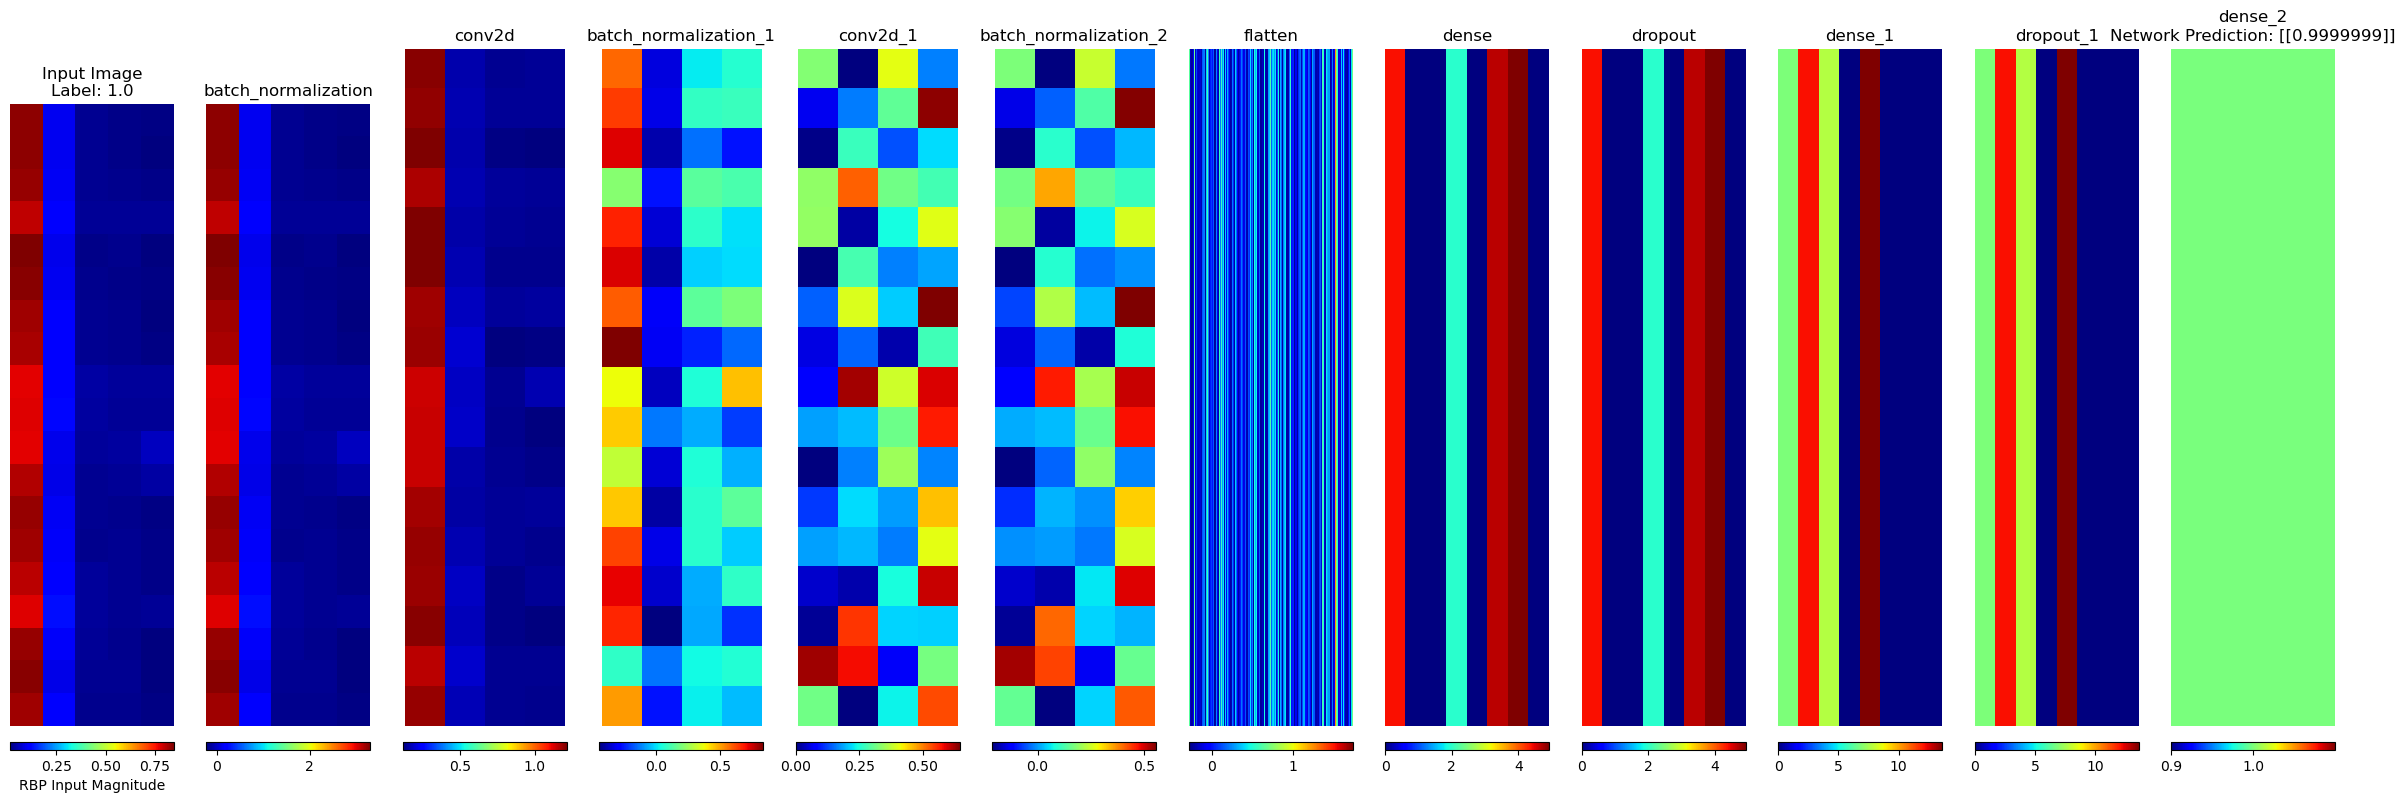

In [22]:
def visualize_activation_maps(model, samples, labels, colormap):
    random_subject_index = np.random.randint(len(samples))
    random_epoch_index = np.random.randint(samples[random_subject_index].shape[0])
    sample = np.expand_dims(samples[random_subject_index][random_epoch_index], axis=0)  # Random subject and epoch
    label = labels[random_subject_index][random_epoch_index]  # Corresponding label

    layer_outputs = [layer.output for layer in model.layers[1:]]  # Skip input layer and flatten layer
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(sample)

    # Original sample
    plt.figure(figsize=(30, 10))
    
    plt.subplot(1, len(activations) + 1, 1)
    plt.imshow(np.squeeze(sample[0]), cmap=colormap)
    plt.title('Input Image\nLabel: {}'.format(label))
    plt.axis('off')
    # Add a colorbar to explain magnitudes of the displayed colors
    cbar = plt.colorbar(orientation='horizontal', fraction=0.1, pad=0.02)
    cbar.set_label('RBP Input Magnitude')  # You can customize the colorbar label if needed


    # Activation maps for each layer
    for i, (layer_name, activation_map) in enumerate(zip([layer.name for layer in model.layers[1:]], activations)):
        plt.subplot(1, len(activations) + 1, i + 2)
        if len(activation_map.shape) == 4:  # 4D activation map (batch_size, width, height, channels)
            # Average activation across channels
            avg_activation = np.mean(activation_map[0], axis=-1)
            plt.imshow(avg_activation, cmap=colormap)
            plt.colorbar(orientation='horizontal', fraction=0.1, pad=0.02)
        elif len(activation_map.shape) == 2:  # 2D activation map (batch_size, features)
            plt.imshow(np.expand_dims(activation_map[0], axis=0), cmap=colormap, aspect='auto')
            plt.colorbar(orientation='horizontal', fraction=0.1, pad=0.02)
        plt.title(layer_name)
        plt.axis('off')

    # Print the network prediction under the title of the last activation map
    prediction = model.predict(sample)
    plt.title('{}\nNetwork Prediction: {}'.format(layer_name, prediction))
    
    # Add a colorbar to explain magnitudes of the displayed colors
    #cbar2 = plt.colorbar(orientation='horizontal', fraction=0.1, pad=0.02)
    #cbar2.set_label('Prediction Magnitude')  # You can customize the colorbar label if needed

    plt.show()

# Example usage
colormap = 'jet'
visualize_activation_maps(model_CNN2D, train_data_rbp2d, train_labels, colormap)


In [113]:
from IPython.display import display
from tensorflow.keras.utils import plot_model

# Visualize the model architecture in the Jupyter Notebook
plot_model(model_CNN2D, show_shapes=True, show_layer_names=True)

# Display the model diagram inline in the Jupyter Notebook
display()


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Model RNN training loop

In [31]:
from sklearn.model_selection import LeaveOneOut
import numpy as np
import tensorflow as tf
import random

train_labels=train_labels_s

num_subjects = len(train_data_rbp)
num_epochs = train_data_rbp[0].shape[0]
num_channels = train_data_rbp[0].shape[1]
num_frequency_bands = train_data_rbp[0].shape[2]

average_accuracy_RNN = []
confusion_true_RNN = []
confusion_pred_RNN = []
histories_RNN = []

learning_rate = 0.005  # Learning rate for the optimizer
beta_1 = 0.9  # Exponential decay rate for the first moment estimates
beta_2 = 0.999  # Exponential decay rate for the second moment estimates
epsilon = 1e-7  # A small constant for numerical stability

ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="accuracy", factor=0.3, patience=4, verbose=1, mode="max", min_lr=0.00005)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",patience=10,verbose=1,mode="max",restore_best_weights=True)

optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
# ... (Assume train_data_rbp2d, train_labels, learning_rate, beta_1, beta_2, epsilon, ReduceLR, EarlyStop are defined)

for subject_idx in range(num_subjects):
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")

    tf.keras.backend.clear_session()

    # RNN Model
    model_RNN = tf.keras.Sequential([
    tf.keras.layers.Reshape((1, num_channels * num_frequency_bands), input_shape=(num_channels, num_frequency_bands)),
    tf.keras.layers.BatchNormalization(),
    
    # First SimpleRNN layer
    tf.keras.layers.LSTM(8, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.5),

    # Second SimpleRNN layer
    tf.keras.layers.LSTM(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(1, activation='sigmoid') 
    ])


    optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

    # Compile RNN Model
    model_RNN.compile(optimizer=optimizer_ADAM, loss='binary_crossentropy', metrics=['accuracy'])

    train_data = []
    train_labels_concat = []

    # Construct the training set excluding current subject's epochs
    for idx, data in enumerate(train_data_rbp):
        if idx != subject_idx:
            # Shuffle the indices for data and corresponding labels
            shuffled_indices = list(range(len(data)))
            random.shuffle(shuffled_indices)
            for shuffled_idx in shuffled_indices:
                train_data.extend(data[shuffled_idx])
                # Convert the label to a list before extending
                train_labels_concat.extend([train_labels[idx][shuffled_idx]])

    # Reshape the training data to match the model's input shape
    train_data_reshaped = np.array(train_data).reshape(-1, num_channels, num_frequency_bands)

    # Train RNN Model
    history_RNN = model_RNN.fit(train_data_reshaped, np.array(train_labels_concat),
                                epochs=20, batch_size=32, verbose=1, callbacks=[EarlyStop, ReduceLR])
    histories_RNN.append(history_RNN)

    # Test on the current subject's epochs
    test_data = np.array(train_data_rbp[subject_idx]).reshape(-1, num_channels, num_frequency_bands)
    test_labels_concat = np.array(train_labels[subject_idx])

    # Predict on test data for RNN
    test_pred_RNN = model_RNN.predict(test_data)
    threshold_RNN = 0.5
    test_pred_binary_RNN = (test_pred_RNN > threshold_RNN).astype(int)
    
    confusion_true_RNN.extend(test_labels_concat)  # Changed from confusion_true_MLP
    confusion_pred_RNN.extend(test_pred_binary_RNN.flatten())  # Changed from confusion_pred_MLP


    # Calculate accuracy manually for RNN
    test_acc_RNN = np.mean(test_pred_binary_RNN == test_labels_concat)
    print(f"RNN Test Accuracy: {test_acc_RNN:.4f}")

    print("=" * 30)

    average_accuracy_RNN.append(test_acc_RNN)

average_accuracy_RNN = np.mean(average_accuracy_RNN)
print(f"Average RNN Test Accuracy: {average_accuracy_RNN:.4f}")
print("Leave-One-Subject-Out validation complete.")


Leave-One-Subject-Out: Testing on subject 1/65
Epoch 1/20
161/161 [==============================] - 4s 4ms/step - loss: 0.6446 - accuracy: 0.6045 - lr: 0.0050
Epoch 2/20
161/161 [==============================] - 1s 4ms/step - loss: 0.5854 - accuracy: 0.7037 - lr: 0.0050
Epoch 3/20
161/161 [==============================] - 1s 4ms/step - loss: 0.5525 - accuracy: 0.7274 - lr: 0.0050
Epoch 4/20
161/161 [==============================] - 1s 4ms/step - loss: 0.5365 - accuracy: 0.7270 - lr: 0.0050
Epoch 5/20
161/161 [==============================] - 1s 4ms/step - loss: 0.5249 - accuracy: 0.7476 - lr: 0.0050
Epoch 6/20
161/161 [==============================] - 1s 4ms/step - loss: 0.4933 - accuracy: 0.7583 - lr: 0.0050
Epoch 7/20
161/161 [==============================] - 1s 4ms/step - loss: 0.4973 - accuracy: 0.7616 - lr: 0.0050
Epoch 8/20
161/161 [==============================] - 1s 4ms/step - loss: 0.4882 - accuracy: 0.7694 - lr: 0.0050
Epoch 9/20
161/161 [=============================

Accuracy: 0.7952936674956954
Precision: 0.8198069360028603
Sensitivity (Recall): 0.8020286813571179
Specificity: 0.7871621621621622
F1-score: 0.8108203677510608


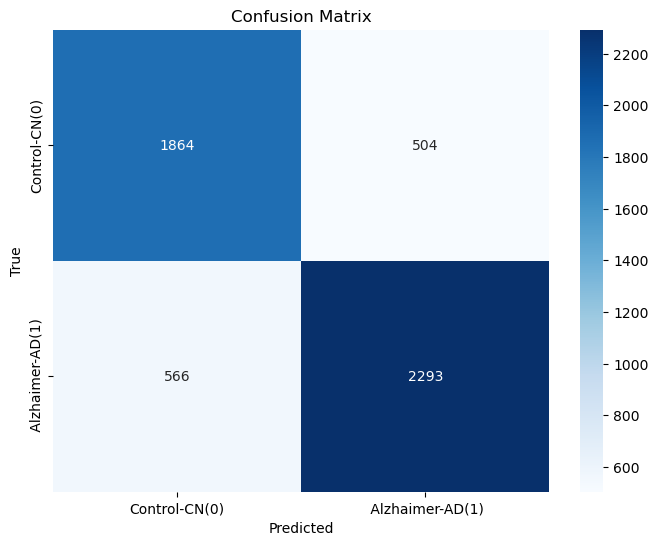

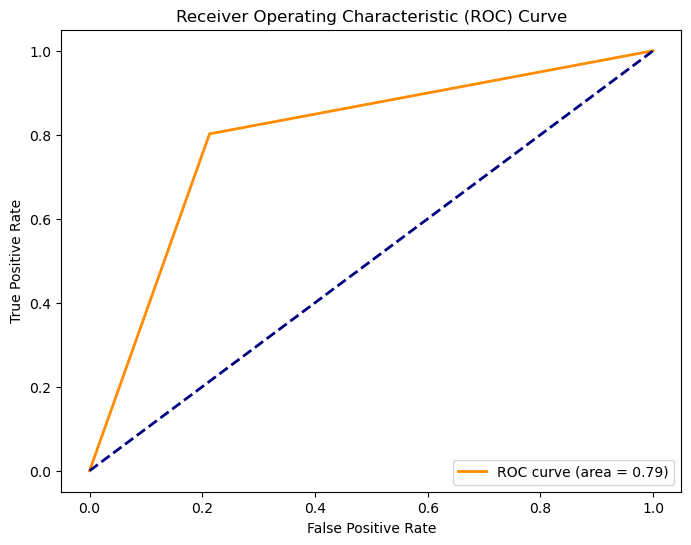

In [26]:
calculate_metrics_and_plot(confusion_true_RNN, confusion_pred_RNN)

Accuracy: 0.7864932083413048
Precision: 0.8118067978533094
Sensitivity (Recall): 0.7936341378104232
Specificity: 0.7778716216216216
F1-score: 0.8026176158471878


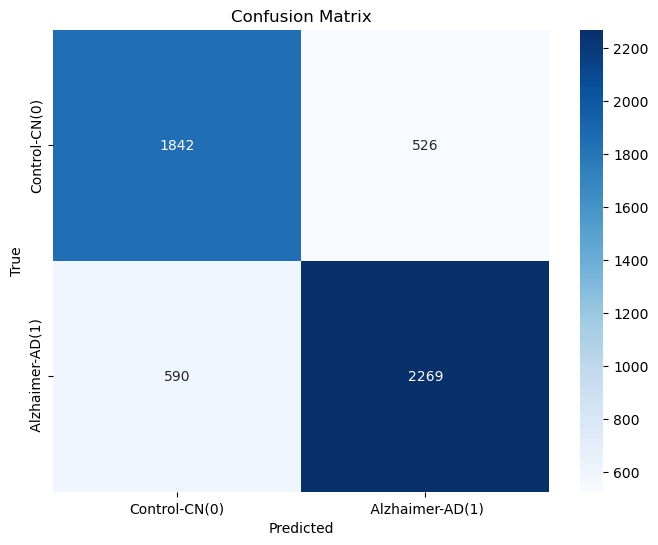

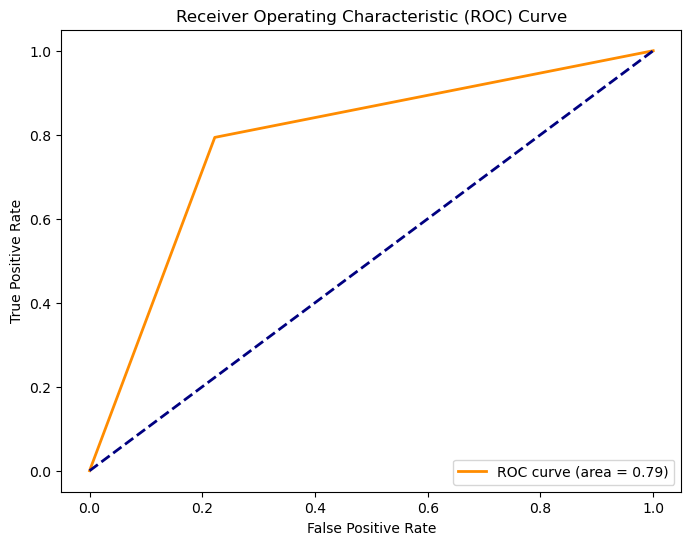

In [32]:
calculate_metrics_and_plot(confusion_true_RNN, confusion_pred_RNN)

In [14]:
#!pip install torch
#!pip install tabpfn
from tabpfn import TabPFNClassifier
import time
from sklearn.metrics import accuracy_score
import warnings
import gc
from sklearn.ensemble import RandomForestClassifier
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns

num_subjects = len(train_data_rbp)
num_epochs = train_data_rbp[0].shape[0]
num_channels = train_data_rbp[0].shape[1]
num_frequency_bands = train_data_rbp[0].shape[2]

def remove_models_from_memory():
    # Iterate over all objects in the global scope
    for obj_name in list(globals()):
        obj = globals()[obj_name]
        if isinstance(obj, torch.nn.Module):
            # If the object is a PyTorch model, delete it
            del globals()[obj_name]
warnings.filterwarnings("ignore", category=UserWarning)
X_new=train_data_rbp
labels=train_labels_s
success_arr = []
predictions = []
predictions_prob = []
for x,y in zip(X_new,labels):
    print(x.shape)
    print(y.shape)
    print(len(x))
    print(len(y))

for current in range(len(X_new)):
    remove_models_from_memory()
    print(f"Leave-One-Subject-Out: Testing on subject {current + 1}/{len(X_new)}")
    classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=5)
    x_train = X_new
    y_train = labels
    x_test = (x_train.pop(current)).reshape(1,-1)
    y_train= np.array(y_train.pop(current))
    x_train = np.concatenate(x_train, axis=0)
    #x_train = np.concatenate(x_train, axis=2)
    print(x_train.shape)
    
    y_test = (y_train.pop(current))
    y_train =  np.concatenate(y_train, axis=0)
    print(y_train.shape)
    classifier.fit(x_train, y_train)
    y_pred, p_pred = classifier.predict(x_test, return_winning_probability=True)
    #clf = RandomForestClassifier(n_estimators=1000, random_state=42)
    
    # Fit the classifier to the training data]
    #clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    #y_pred = clf.predict(x_test)
    predictions.append(y_pred)
    predictions_prob.append(p_pred)
    
confusion_mtx = confusion_matrix(labels, predictions)

# Define class names
class_names = ["Control group(0)", "Alzheimer group(1)"]

# Calculate accuracy, sensitivity, specificity, precision, and F1-score
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)
specificity = confusion_mtx[0, 0] / (confusion_mtx[0, 0] + confusion_mtx[0, 1])

# Output metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Sensitivity (Recall):", recall)
print("Specificity:", specificity)
print("F1-score:", f1)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(labels, predictions_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


(83, 19, 5)
(83,)
83
83
(81, 19, 5)
(81,)
81
81
(82, 19, 5)
(82,)
82
82
(79, 19, 5)
(79,)
79
79
(97, 19, 5)
(97,)
97
97
(78, 19, 5)
(78,)
78
78
(84, 19, 5)
(84,)
84
84
(95, 19, 5)
(95,)
95
95
(79, 19, 5)
(79,)
79
79
(75, 19, 5)
(75,)
75
75
(87, 19, 5)
(87,)
87
87
(87, 19, 5)
(87,)
87
87
(77, 19, 5)
(77,)
77
77
(77, 19, 5)
(77,)
77
77
(76, 19, 5)
(76,)
76
76
(80, 19, 5)
(80,)
80
80
(79, 19, 5)
(79,)
79
79
(78, 19, 5)
(78,)
78
78
(74, 19, 5)
(74,)
74
74
(84, 19, 5)
(84,)
84
84
(88, 19, 5)
(88,)
88
88
(87, 19, 5)
(87,)
87
87
(95, 19, 5)
(95,)
95
95
(77, 19, 5)
(77,)
77
77
(88, 19, 5)
(88,)
88
88
(127, 19, 5)
(127,)
127
127
(60, 19, 5)
(60,)
60
60
(69, 19, 5)
(69,)
69
69
(75, 19, 5)
(75,)
75
75
(79, 19, 5)
(79,)
79
79
(72, 19, 5)
(72,)
72
72
(91, 19, 5)
(91,)
91
91
(54, 19, 5)
(54,)
54
54
(96, 19, 5)
(96,)
96
96
(95, 19, 5)
(95,)
95
95
(114, 19, 5)
(114,)
114
114
(73, 19, 5)
(73,)
73
73
(81, 19, 5)
(81,)
81
81
(83, 19, 5)
(83,)
83
83
(78, 19, 5)
(78,)
78
78
(85, 19, 5)
(85,)
85
85
(78, 19,

AttributeError: 'numpy.ndarray' object has no attribute 'pop'

In [35]:
from sklearn.model_selection import LeaveOneOut
import numpy as np
import tensorflow as tf
import random 
#!pip install torch
#!pip install tabpfn
from tabpfn import TabPFNClassifier
import time
from sklearn.metrics import accuracy_score
import warnings
import gc
from sklearn.ensemble import RandomForestClassifier
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns



train_labels=train_labels_s

def remove_models_from_memory():
    # Iterate over all objects in the global scope
    for obj_name in list(globals()):
        obj = globals()[obj_name]
        if isinstance(obj, torch.nn.Module):
            # If the object is a PyTorch model, delete it
            del globals()[obj_name]
warnings.filterwarnings("ignore", category=UserWarning)


average_accuracy = []

true_labels=[]
predictions_prob=[]
predictions=[]
for subject_idx in range(num_subjects):
    remove_models_from_memory()
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")

    train_data = []
    train_labels_concat = []

    # Construct the training set excluding current subject's epochs
    for idx, data in enumerate(train_data_rbp):
        if idx != subject_idx:
            # Shuffle the indices for data and corresponding labels
            shuffled_indices = list(range(len(data)))
            random.shuffle(shuffled_indices)
            for shuffled_idx in shuffled_indices:
                train_data.extend(data[shuffled_idx])
                # Convert the label to a list before extending
                train_labels_concat.extend([train_labels[idx][shuffled_idx]])
                
    # Reshape the training data to match the model's input shape
    train_data_reshaped = np.array(train_data).reshape(-1, num_channels* num_frequency_bands)

    classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=5)
    print(train_data_reshaped.shape)
    print (np.array(train_labels_concat).shape)
    classifier.fit(train_data_reshaped, np.array(train_labels_concat),overwrite_warning=True)
    
 
  

    # Test on the current subject's epochs
    test_data = np.array(train_data_rbp[subject_idx]).reshape(-1, num_channels* num_frequency_bands)
    test_labels_concat = np.array(train_labels[subject_idx])

    # Predict on test data
    y_pred, p_pred = classifier.predict(test_data, return_winning_probability=True)
       # Calculate accuracy manually
    test_acc = np.mean(y_pred == test_labels_concat)

    print(f"Test Accuracy: {test_acc:.4f}")
    true_labels.append(test_labels_concat)
    predictions.append(y_pred)
    
    predictions_prob.append(p_pred)

  


print("Leave-One-Subject-Out validation complete.")


Leave-One-Subject-Out: Testing on subject 1/65
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
(5143, 95)
(5143,)


C:\Anaconda\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2116035920 bytes.

In [ ]:
from sklearn.metrics import confusion_matrix

true_labels_flat = np.concatenate(true_labels)
predictions_flat = np.concatenate(predictions)
predictions_prob_flat = np.concatenate(predictions_prob)

confusion_mtx = confusion_matrix(true_labels_flat, predictions_flat)

# Define class names
class_names = ["Control group(0)", "Alzheimer group(1)"]

# Calculate accuracy, sensitivity, specificity, precision, and F1-score
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)
specificity = confusion_mtx[0, 0] / (confusion_mtx[0, 0] + confusion_mtx[0, 1])

# Output metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Sensitivity (Recall):", recall)
print("Specificity:", specificity)
print("F1-score:", f1)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(labels, predictions_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
